# Import dataset-a sa kojim radimo u nastavku

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
ZIP_PATH = "/content/drive/MyDrive/train.zip"  # promeni
!unzip -q "$ZIP_PATH" -d /content/dataset
!ls -lah /content/dataset


total 280K
drwxr-xr-x 4 root root 4.0K Jan 20 15:23 .
drwxr-xr-x 1 root root 4.0K Jan 20 15:23 ..
drwxr-xr-x 2 root root 136K Jul 16  2018 images
drwxr-xr-x 2 root root 136K Jul 16  2018 masks


# Uvod

U okviru Kontrolne tačke 2 cilj je analiza dodeljenog skupa podataka za zadatak salt segmentation (semantička segmentacija soli na seizmičkim slikama), sprovođenje osnovnog pretprocesiranja i izrada jednostavnog baseline modela kao polazne osnove za kasniju optimizaciju. Na osnovu teorijskih uvida iz Kontrolne tačke 1 (šum u seizmičkim zapisima, nejasne granice između soli i sedimenata, kao i neuravnoteženost klasa), u ovom notebook-u ćemo: (1) opisati karakteristike dataset-a (broj uzoraka, format i dimenzije slika, binarne maske), (2) vizualizovati reprezentativne primere i raspodelu klasa, (3) primeniti osnovne transformacije (resize, normalizacija i minimalna augmentacija), i (4) trenirati i evaluirati baseline model koristeći osnovne metrike (Accuracy, F1-score i Confusion Matrix). Dobijeni rezultati služe kao početna tačka i referenca za naredne faze projekta.

In [6]:
import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

print("Ready")

Ready


## Analiza i opis dataset-a

Dataset za salt segmentation sadrži ukupno 4000 grayscale seizmičkih slika u PNG formatu i odgovarajućih 4000 binarnih maski (1:1 mapiranje po imenu fajla). Zadatak je binarna semantička segmentacija, gde se svaki piksel klasifikuje kao salt (1) ili background/sediment (0). U nastavku se proveravaju dimenzije slika, format (grayscale), binarnost maski, kao i potencijalne nepravilnosti poput različitih dimenzija, prisustva praznih maski i indikacija šuma/kontrasta.

In [7]:
import os, glob

DATA_ROOT = "/content/dataset"

train_images_dir = os.path.join(DATA_ROOT, "images")
train_masks_dir  = os.path.join(DATA_ROOT, "masks")

print("Train images:", train_images_dir, "exists:", os.path.isdir(train_images_dir))
print("Train masks :", train_masks_dir,  "exists:", os.path.isdir(train_masks_dir))

assert os.path.isdir(train_images_dir), "Ne postoji images folder na očekivanoj putanji."
assert os.path.isdir(train_masks_dir), "Ne postoji masks folder na očekivanoj putanji."

image_paths = sorted(glob.glob(os.path.join(train_images_dir, "*")))
mask_paths  = sorted(glob.glob(os.path.join(train_masks_dir, "*")))

print("Broj slika:", len(image_paths))
print("Broj maski:", len(mask_paths))
print("Primer slike:", os.path.basename(image_paths[0]))
print("Primer maske:", os.path.basename(mask_paths[0]))



Train images: /content/dataset/images exists: True
Train masks : /content/dataset/masks exists: True
Broj slika: 4000
Broj maski: 4000
Primer slike: 000e218f21.png
Primer maske: 000e218f21.png


### Proveri format + dimenzije

In [9]:
# Provera formata i dimenzija na uzorku (npr. 200 slika)
sample_n = 200
sample_paths = random.sample(image_paths, k=min(sample_n, len(image_paths)))

modes = []
sizes = []
for p in sample_paths:
    img = Image.open(p)
    modes.append(img.mode)     # 'L' očekujemo za grayscale
    sizes.append(img.size)     # (W,H)

unique_modes = sorted(set(modes))
unique_sizes = sorted(set(sizes))

print("Mode-ovi (očekuje se 'L'):", unique_modes)
print("Broj različitih dimenzija (u uzorku):", len(unique_sizes))
print("Dimenzija (primer):", unique_sizes[0])


Mode-ovi (očekuje se 'L'): ['RGB']
Broj različitih dimenzija (u uzorku): 1
Dimenzija (primer): (101, 101)


### Provera binarnost maski

In [10]:
# Provera binarnosti maski (uzorak)
sample_m = 200
sample_mask_paths = random.sample(mask_paths, k=min(sample_m, len(mask_paths)))

unique_values_sets = []
for p in sample_mask_paths:
    m = np.array(Image.open(p))
    unique_values_sets.append(set(np.unique(m)))

# spoji sve vrednosti koje se pojavljuju u uzorku
all_vals = sorted(set().union(*unique_values_sets))
print("Vrednosti piksela u maskama (uzorak):", all_vals[:20], "...")
print("Ukupno različitih vrednosti (uzorak):", len(all_vals))


Vrednosti piksela u maskama (uzorak): [np.uint8(0), np.uint16(65535)] ...
Ukupno različitih vrednosti (uzorak): 2


### Balansiranost (pixel-level) + prazne maske

In [11]:
def salt_ratio(mask_arr):
    # binarizacija praga
    bin_mask = (mask_arr > 127).astype(np.uint8)
    return bin_mask.mean()  # udeo salt piksela

sample_k = 500  # dovoljno reprezentativno
sample_mask_paths = random.sample(mask_paths, k=min(sample_k, len(mask_paths)))

ratios = []
for p in sample_mask_paths:
    m = np.array(Image.open(p))
    ratios.append(salt_ratio(m))

ratios = np.array(ratios)

print("Uzorak maski:", len(ratios))
print("Prosečan udeo salt piksela:", float(ratios.mean()))
print("Mediana:", float(np.median(ratios)))
print("Min/Max:", float(ratios.min()), float(ratios.max()))

# Koliko maski je skoro prazno (npr. <1% salt piksela)
empty_like = np.mean(ratios < 0.01)
print("Udeo skoro praznih maski (<1% salt):", float(empty_like))


Uzorak maski: 500
Prosečan udeo salt piksela: 0.25812665424958336
Mediana: 0.06185668071757671
Min/Max: 0.0 0.9999019703950593
Udeo skoro praznih maski (<1% salt): 0.418


In [8]:
image_paths = sorted(glob.glob(os.path.join(train_images_dir, "*")))
mask_paths  = sorted(glob.glob(os.path.join(train_masks_dir, "*")))

print("Broj train slika:", len(image_paths))
print("Broj maski      :", len(mask_paths))
print("Primer slike:", os.path.basename(image_paths[0]))
print("Primer maske:", os.path.basename(mask_paths[0]))

# Provera da li imena 1:1 odgovaraju
same_names = os.path.basename(image_paths[0]) in set(map(os.path.basename, mask_paths))
print("Imena se poklapaju:", same_names)


Broj train slika: 4000
Broj maski      : 4000
Primer slike: 000e218f21.png
Primer maske: 000e218f21.png
Imena se poklapaju: True


###Zaključak analize dataset-a

Na osnovu sprovedene analize, može se zaključiti da dataset sadrži 4000 seizmičkih slika i 4000 odgovarajućih maski, sa potpunim 1:1 mapiranjem po imenu fajla. Sve slike imaju uniformne dimenzije (101×101 piksela) i kodirane su u RGB formatu, pri čemu svi kanali nose istu informaciju, što ukazuje da je sadržaj suštinski grayscale. Maske su binarne, kodirane kao 16-bitne slike sa vrednostima 0 i maksimalnom vrednošću (65535), što zahteva dodatnu binarizaciju tokom pretprocesiranja.

Analiza raspodele klasa na nivou piksela pokazuje da je dataset značajno neuravnotežen: prosečan udeo pikselа koji pripadaju klasi salt iznosi oko 26%, dok je medijana znatno niža (≈6%), što ukazuje da veliki broj slika sadrži veoma male solne strukture. Dodatno, približno 42% maski sadrži manje od 1% salt piksela, što predstavlja potencijalni izazov za treniranje modela i može dovesti do favorizovanja dominantne background klase. Ovi nalazi su u skladu sa teorijskim izazovima opisanim u Kontrolnoj tački 1 i motivišu pažljivo pretprocesiranje i izbor odgovarajućih metrika evaluacije u narednim fazama.

# Vizualizacija uzoraka i raspodele klasa

U nastavku su prikazani reprezentativni primeri seizmičkih slika i odgovarajućih binarnih maski, kao i vizualizacija raspodele klasa na nivou piksela (udeo salt piksela u odnosu na background). Cilj je da se kvalitativno uoče tipični oblici solnih struktura, kao i izazovi poput šuma, slabog kontrasta i nejasnih granica.

### Prikaz primera (image + mask + overlay)

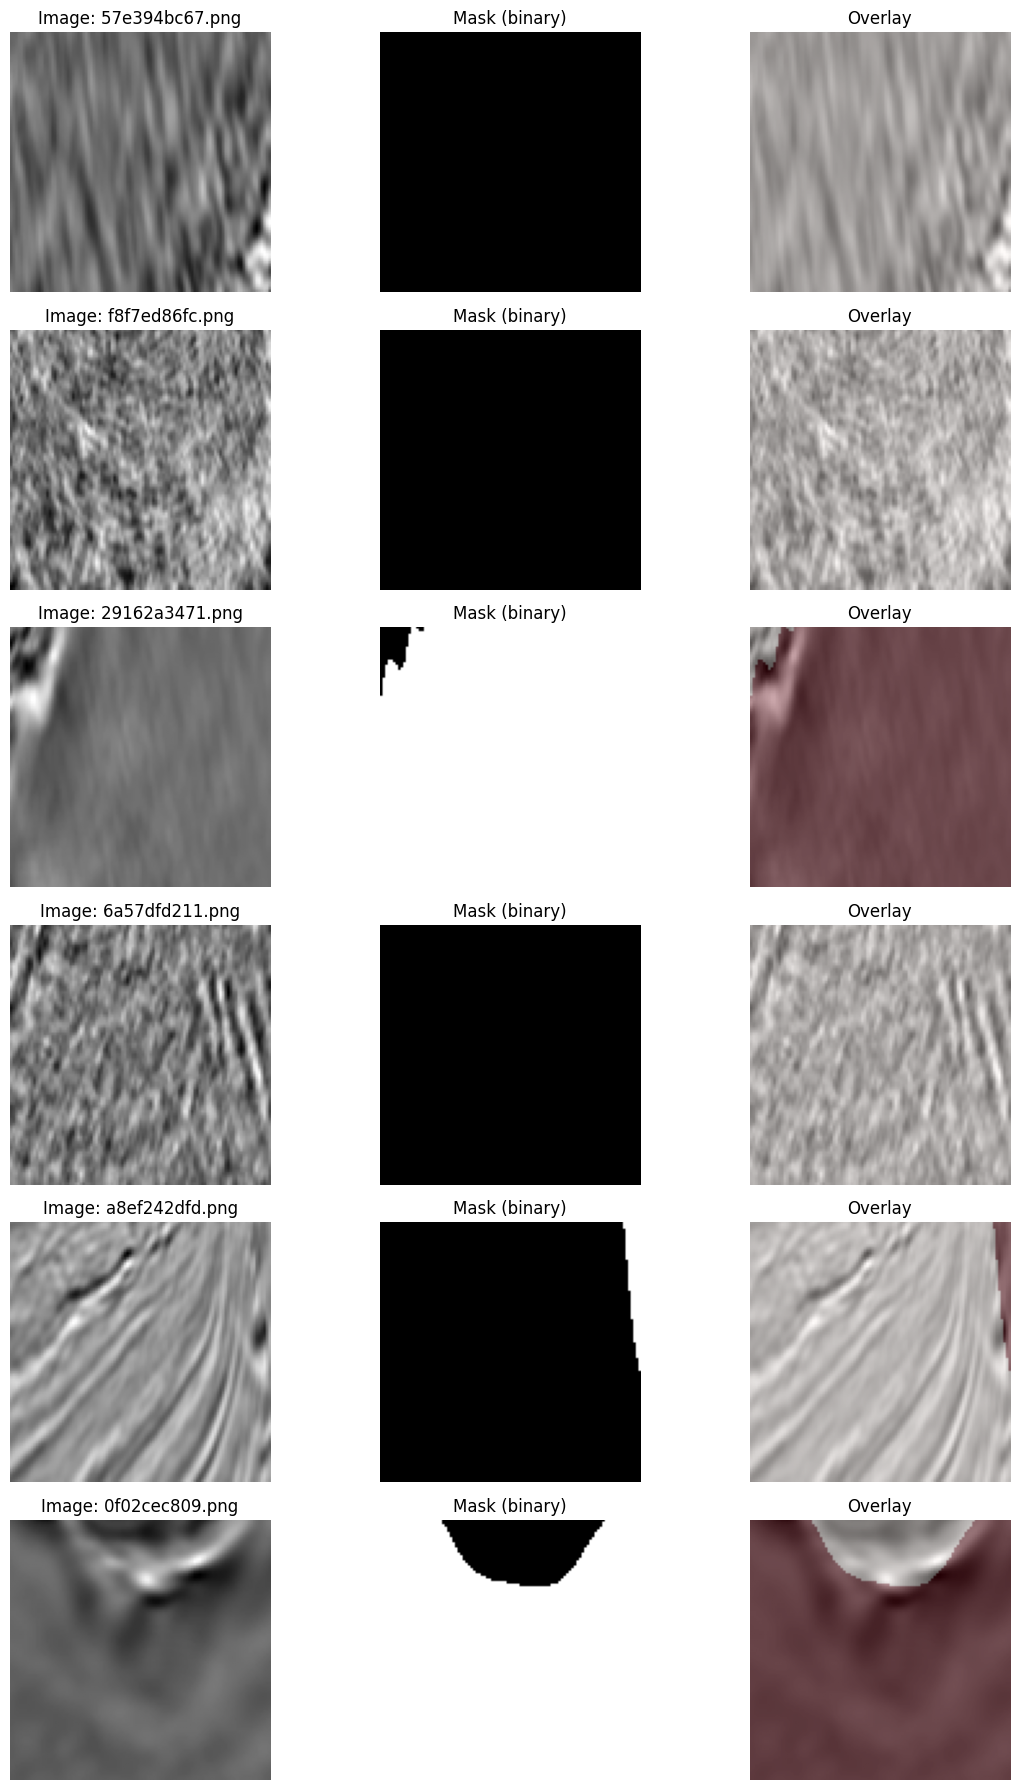

In [12]:
def to_gray(arr):
    # Ako je RGB, uzmi prvi kanal (tipično su sva 3 ista). Ako nije, vrati kako jeste.
    if arr.ndim == 3:
        return arr[..., 0]
    return arr

def show_samples(n=6, seed=42):
    random.seed(seed)
    idxs = random.sample(range(len(image_paths)), k=n)

    plt.figure(figsize=(12, 3*n))
    for row, idx in enumerate(idxs):
        img = np.array(Image.open(image_paths[idx]))
        msk = np.array(Image.open(mask_paths[idx]))

        img_g = to_gray(img)
        # maska je 16-bit (0/65535), binarizuj za overlay i prikaz
        msk_bin = (msk > 0).astype(np.uint8)

        # 1) original
        plt.subplot(n, 3, 3*row + 1)
        plt.imshow(img_g, cmap="gray")
        plt.title(f"Image: {os.path.basename(image_paths[idx])}")
        plt.axis("off")

        # 2) maska
        plt.subplot(n, 3, 3*row + 2)
        plt.imshow(msk_bin, cmap="gray")
        plt.title("Mask (binary)")
        plt.axis("off")

        # 3) overlay
        plt.subplot(n, 3, 3*row + 3)
        plt.imshow(img_g, cmap="gray")
        plt.imshow(msk_bin, cmap="Reds", alpha=0.35)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(n=6, seed=7)


### Histogram raspodele

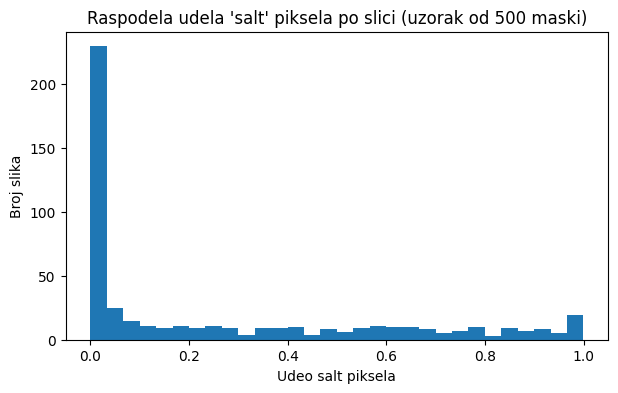

In [13]:
plt.figure(figsize=(7,4))
plt.hist(ratios, bins=30)
plt.title("Raspodela udela 'salt' piksela po slici (uzorak od 500 maski)")
plt.xlabel("Udeo salt piksela")
plt.ylabel("Broj slika")
plt.show()


### Bar chart prosecnog odnosa(salt/background)

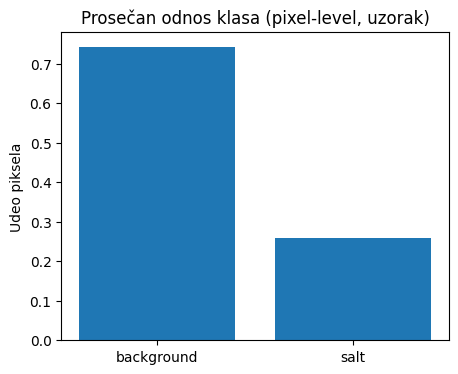

Prosečan udeo salt: 0.25812665424958336
Prosečan udeo background: 0.7418733457504166


In [14]:
avg_salt = float(ratios.mean())
avg_bg = 1.0 - avg_salt

plt.figure(figsize=(5,4))
plt.bar(["background", "salt"], [avg_bg, avg_salt])
plt.title("Prosečan odnos klasa (pixel-level, uzorak)")
plt.ylabel("Udeo piksela")
plt.show()

print("Prosečan udeo salt:", avg_salt)
print("Prosečan udeo background:", avg_bg)


### Prikaz koliko je skoro praznih maski

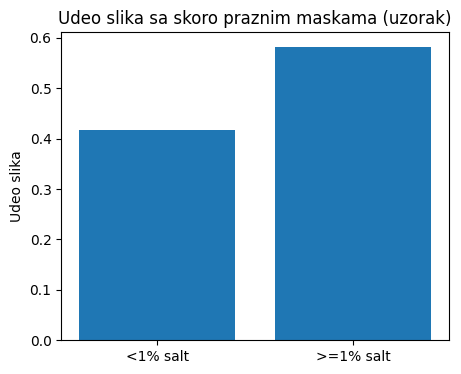

Udeo skoro praznih maski (<1% salt): 0.418


In [15]:
empty_like = float(np.mean(ratios < 0.01))
plt.figure(figsize=(5,4))
plt.bar(["<1% salt", ">=1% salt"], [empty_like, 1-empty_like])
plt.title("Udeo slika sa skoro praznim maskama (uzorak)")
plt.ylabel("Udeo slika")
plt.show()

print("Udeo skoro praznih maski (<1% salt):", empty_like)


Vizualizacije potvrđuju da solne strukture mogu imati vrlo različite oblike i veličine, kao i da se granice između soli i okolnih sedimenata često pojavljuju kao “meke” ili nejasne, što otežava preciznu segmentaciju. Histogram raspodele udela salt piksela pokazuje izraženu neuravnoteženost: veliki broj slika sadrži veoma mali procenat soli, dok manji broj primera ima dominantnu solnu strukturu. Ovakva raspodela motiviše korišćenje metrika poput F1/Dice i pažljiv izbor pretprocesiranja i baseline pristupa.

# Pretprocesiranje

Pre treniranja baseline modela sprovodi se osnovno pretprocesiranje kako bi podaci bili ujednačeni i pogodni za učenje. Seizmičke slike su kodirane kao RGB, ali nose suštinski grayscale informaciju, pa se koristi jedan kanal (1-kanalni ulaz). Zbog efikasnosti treninga i ujednačavanja ulaza, slike i maske se skaliraju na fiksnu dimenziju 128×128. Intenziteti piksela se normalizuju u opseg [0, 1], što stabilizuje optimizaciju. Maske su binarne i 16-bitne (0 i 65535), pa se binarizuju pragom (>0) i mapiraju u {0,1}. Kao minimalna augmentacija koristi se horizontalni flip, kako bi se povećala varijabilnost uzoraka i smanjio rizik od overfitting-a, bez narušavanja semantike seizmičkih struktura.

### Parametri + split (train/val)

In [21]:
import tensorflow as tf
from tensorflow import keras

IMG_SIZE = 128
BATCH_SIZE = 16
SEED = 42

# Napravi listu parova (img, mask) 1:1 po imenu
mask_map = {os.path.basename(p): p for p in mask_paths}
pairs = [(ip, mask_map[os.path.basename(ip)]) for ip in image_paths if os.path.basename(ip) in mask_map]

random.seed(SEED)
random.shuffle(pairs)

split = int(0.85 * len(pairs))
train_pairs = pairs[:split]
val_pairs = pairs[split:]

print("Train pairs:", len(train_pairs))
print("Val pairs:  ", len(val_pairs))


Train pairs: 3400
Val pairs:   600


### Funkcija za učitavanje + Pretprocesiranje

In [17]:
def load_image_mask(img_path, mask_path):
    # --- IMAGE ---
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)   # RGB (kodirano)
    img = img[..., :1]                           # uzmi 1 kanal -> (H,W,1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0       # [0,1]

    # --- MASK ---
    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_png(msk, channels=1)   # može biti 16-bit
    msk = tf.image.resize(msk, (IMG_SIZE, IMG_SIZE), method="nearest")
    # binarizacija (0 i 65535 -> 0/1)
    msk = tf.cast(msk > 0, tf.float32)

    return img, msk


### Minimalna augmentacija

In [18]:
def augment(img, msk):
    # horizontal flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        msk = tf.image.flip_left_right(msk)
    return img, msk


### tf.data pipeline

tf.data pipeline predstavlja efikasan mehanizam u TensorFlow-u za učitavanje, pretprocesiranje i isporuku podataka tokom treniranja modela. Umesto da se svi podaci učitavaju unapred u memoriju, tf.data omogućava da se podaci obrađuju “u hodu” (on-the-fly), u batch-evima, uz paralelno izvršavanje operacija poput resize-a, normalizacije i augmentacije.

In [19]:
def make_dataset(pairs, training=False):
    img_paths = [p[0] for p in pairs]
    msk_paths = [p[1] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, msk_paths))
    if training:
        ds = ds.shuffle(buffer_size=len(pairs), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_pairs, training=True)
val_ds = make_dataset(val_pairs, training=False)

print(train_ds, val_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


### Vizuelna provera posle pretprocesiranja

Batch images: (16, 128, 128, 1) <dtype: 'float32'>
Batch masks : (16, 128, 128, 1) <dtype: 'float32'>
Image min/max: 0.0 0.9982750415802002
Mask unique (prva maska): [0. 1.]


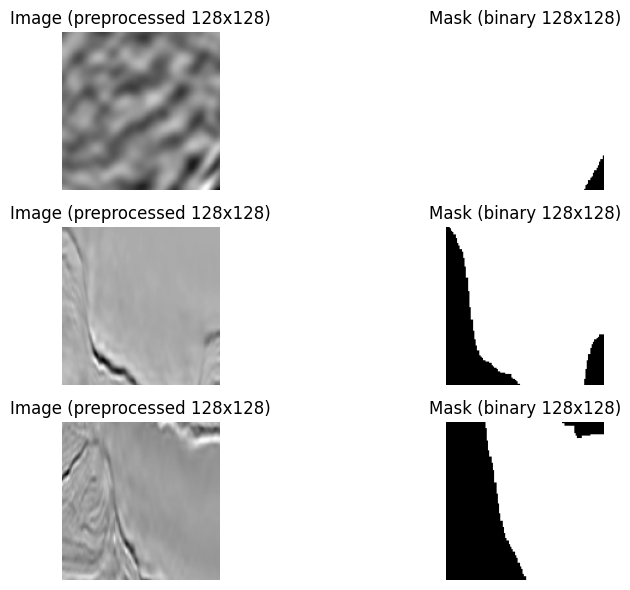

In [20]:
imgs, msks = next(iter(train_ds))
print("Batch images:", imgs.shape, imgs.dtype)
print("Batch masks :", msks.shape, msks.dtype)
print("Image min/max:", float(tf.reduce_min(imgs)), float(tf.reduce_max(imgs)))
print("Mask unique (prva maska):", np.unique(msks[0].numpy()))

plt.figure(figsize=(10,6))
for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.imshow(tf.squeeze(imgs[i]), cmap="gray")
    plt.title("Image (preprocessed 128x128)")
    plt.axis("off")

    plt.subplot(3,2,2*i+2)
    plt.imshow(tf.squeeze(msks[i]), cmap="gray")
    plt.title("Mask (binary 128x128)")
    plt.axis("off")

plt.tight_layout()
plt.show()


Sprovedeno pretprocesiranje obezbedilo je ujednačen i stabilan ulaz za treniranje baseline modela. Seizmičke slike, iako kodirane u RGB formatu, sadrže suštinski grayscale informaciju, pa je korišćen jedan kanal kako bi se smanjila redundantnost i pojednostavio ulaz u mrežu. Slike i maske su skalirane na fiksnu dimenziju 128×128, čime je postignuta uniformnost podataka i efikasniji trening. Intenziteti slika su normalizovani u opseg [0,1], dok su binarne maske pravilno konvertovane iz 16-bitnog zapisa (0 i 65535) u {0,1}, bez gubitka semantičkih granica.

Minimalna augmentacija u vidu horizontalnog flip-a dodatno povećava raznovrsnost podataka i doprinosi smanjenju overfitting-a, bez narušavanja geološkog značenja struktura. Vizuelna provera nakon pretprocesiranja potvrđuje da su granice solnih struktura očuvane i da su podaci adekvatno pripremljeni za narednu fazu — treniranje i evaluaciju baseline modela.

# Baseline model i rezultati

U ovoj fazi se implementira i trenira jednostavan baseline model za binarnu semantičku segmentaciju (salt vs background). Izabran je mali encoder–decoder CNN bez skip konekcija, kako bi arhitektura ostala jednostavna i predstavljala referentnu tačku za kasnije unapređenje (npr. U-Net, napredniji loss, attention). Model prima pretprocesirane 1-kanalne slike dimenzije 128×128 i vraća predikciju maske iste dimenzije, pri čemu se na izlazu koristi sigmoid aktivacija.

### Definicija baseline CNN modela

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_baseline_model(img_size=IMG_SIZE):
    inputs = keras.Input(shape=(img_size, img_size, 1))

    # Encoder (ekstrakcija karakteristika)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    # Bottleneck
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # Decoder (rekonstrukcija maske)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)

    # Output: 1 kanal, sigmoid za verovatnoću klase "salt"
    outputs = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(x)

    return keras.Model(inputs, outputs, name="baseline_cnn_seg")

model = build_baseline_model()
model.summary()


Model: "baseline_cnn_seg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 1)    │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,049 (758.00 KB)

 Trainable params: 194,049 (758.00 KB)

 Non-trainable params: 0 (0.00 B)

**Objašnjenje arhitekture**
- Model je organizovan kao encoder–decoder: encoder postepeno smanjuje rezoluciju (MaxPooling) i uči sve apstraktnije karakteristike, dok decoder vraća rezoluciju (UpSampling) i proizvodi masku. Ovaj model namerno ne koristi skip konekcije (za razliku od U-Net-a) kako bi ostao jednostavan baseline. Sigmoid na izlazu daje verovatnoću da svaki piksel pripada klasi salt.

### Kompajliranje modela (loss + metrike)

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")]
)


Za baseline koristimo binarnu cross-entropy (BCE), standardan izbor za binarnu segmentaciju sa sigmoid izlazom. Tokom treninga pratimo pixel-wise accuracy, ali zbog neuravnoteženosti klasa (dominantna background klasa) accuracy može biti varljiv, pa se nakon treninga dodatno računaju F1-score i Confusion Matrix na nivou piksela.

### Trening

In [26]:
EPOCHS = 8

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.7555 - loss: 0.5178 - val_accuracy: 0.8438 - val_loss: 0.3922
Epoch 2/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.8454 - loss: 0.3828 - val_accuracy: 0.8564 - val_loss: 0.4224
Epoch 3/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8594 - loss: 0.3633 - val_accuracy: 0.8349 - val_loss: 0.3760
Epoch 4/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8730 - loss: 0.3265 - val_accuracy: 0.8616 - val_loss: 0.3358
Epoch 5/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8753 - loss: 0.3184 - val_accuracy: 0.8694 - val_loss: 0.3285
Epoch 6/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.8809 - loss: 0.3034 - val_accuracy: 0.8922 - val_loss: 0.2915
Epoch 7/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.8936 - loss: 0.2800 - val_accuracy: 0.8806 - val_loss: 0.3319
Epoch 8/8
213/213 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.8897 - loss: 0.2809 - val_accuracy: 0.

Model se trenira nekoliko epoha na pretprocesiranim slikama (128×128) uz validacioni skup. Cilj nije postizanje maksimalnih performansi, već dobijanje početne referentne tačke i uvida u to da li jednostavan model može da uoči obrasce soli u seizmičkim slikama.

### Krive učenja

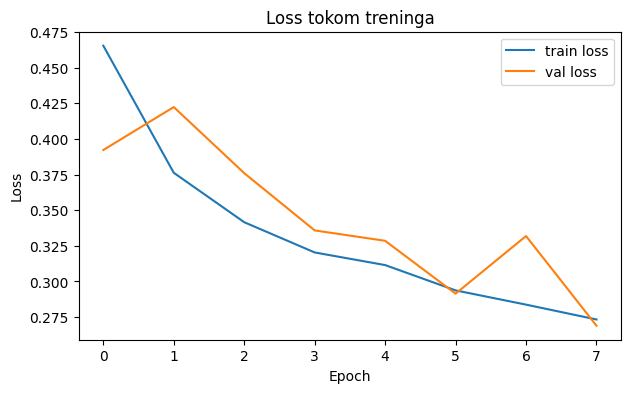

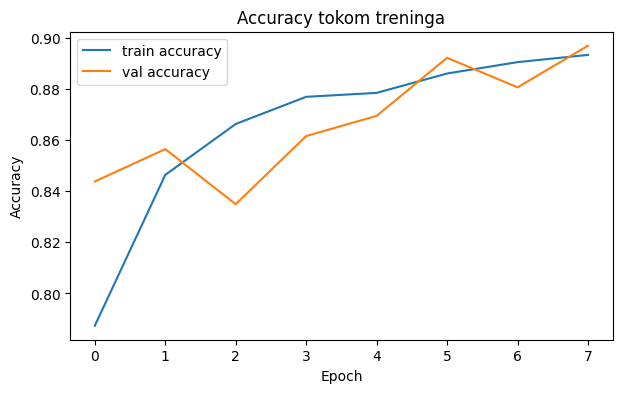

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Loss tokom treninga")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.title("Accuracy tokom treninga")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Prikaz loss i accuracy krivih pomaže u proceni da li model uči stabilno i da li postoji indikacija overfitting-a (npr. train loss opada dok val loss raste). Ovo je važan deo osnovne evaluacije u CP2 jer povezuje kvalitet podataka/pretprocesiranja i ponašanje modela tokom treninga.

### Evaluacija: Confusion Matrix + Accuracy + Precision/Recall/F1

In [29]:
import numpy as np

def evaluate_pixel_metrics(model, ds, threshold=0.5):
    TP = FP = TN = FN = 0

    for batch_imgs, batch_msks in ds:
        preds = model.predict(batch_imgs, verbose=0)
        preds_bin = (preds > threshold).astype(np.uint8)
        true_bin  = (batch_msks.numpy() > 0.5).astype(np.uint8)

        p = preds_bin.reshape(-1)
        t = true_bin.reshape(-1)

        TP += np.sum((p==1) & (t==1))
        TN += np.sum((p==0) & (t==0))
        FP += np.sum((p==1) & (t==0))
        FN += np.sum((p==0) & (t==1))

    acc = (TP+TN) / (TP+TN+FP+FN+1e-9)
    precision = TP / (TP+FP+1e-9)
    recall = TP / (TP+FN+1e-9)
    f1 = 2*precision*recall / (precision+recall+1e-9)

    return TP, TN, FP, FN, acc, precision, recall, f1

TP, TN, FP, FN, acc, precision, recall, f1 = evaluate_pixel_metrics(model, val_ds)

print("Pixel-wise metrics (validation):")
print("TP:", TP, "TN:", TN, "FP:", FP, "FN:", FN)
print("Accuracy :", acc)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 score :", f1)


Pixel-wise metrics (validation):
TP: 1670755 TN: 7145865 FP: 318431 FN: 695349
Accuracy : 0.8968729654947915
Precision: 0.8399189417178681
Recall   : 0.7061206946102113
F1 score : 0.767230195426404


Pošto je zadatak segmentacija, evaluacija se vrši na nivou piksela: svaki piksel se posmatra kao binarni primer (salt ili background). Izračunavaju se TP/TN/FP/FN, a zatim Accuracy, Precision, Recall i F1-score. F1-score je posebno važan zbog neuravnoteženosti klasa, jer bolje odražava performanse na manjinskoj klasi (salt) u odnosu na samu accuracy metriku.

### Prikaz Confusion Matrix

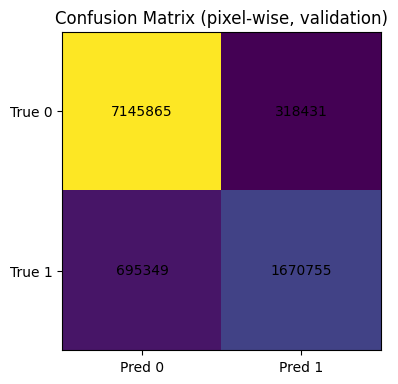

In [30]:
cm = np.array([[TN, FP],
               [FN, TP]])

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title("Confusion Matrix (pixel-wise, validation)")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm[i,j]}", ha="center", va="center")

plt.tight_layout()
plt.show()


Confusion Matrix prikazuje raspodelu tačnih i pogrešnih predikcija na nivou piksela. U kontekstu ovog zadatka, posebno su važni FN (salt pikseli predviđeni kao background) i FP (background pikseli predviđeni kao salt), jer ukazuju na tip grešaka koje model pravi i pomažu u planiranju narednih poboljšanja (npr. drugačiji loss ili bolja arhitektura).

### Kvalitativna evaluacija: prikaži predikcije (image / true mask / pred mask)

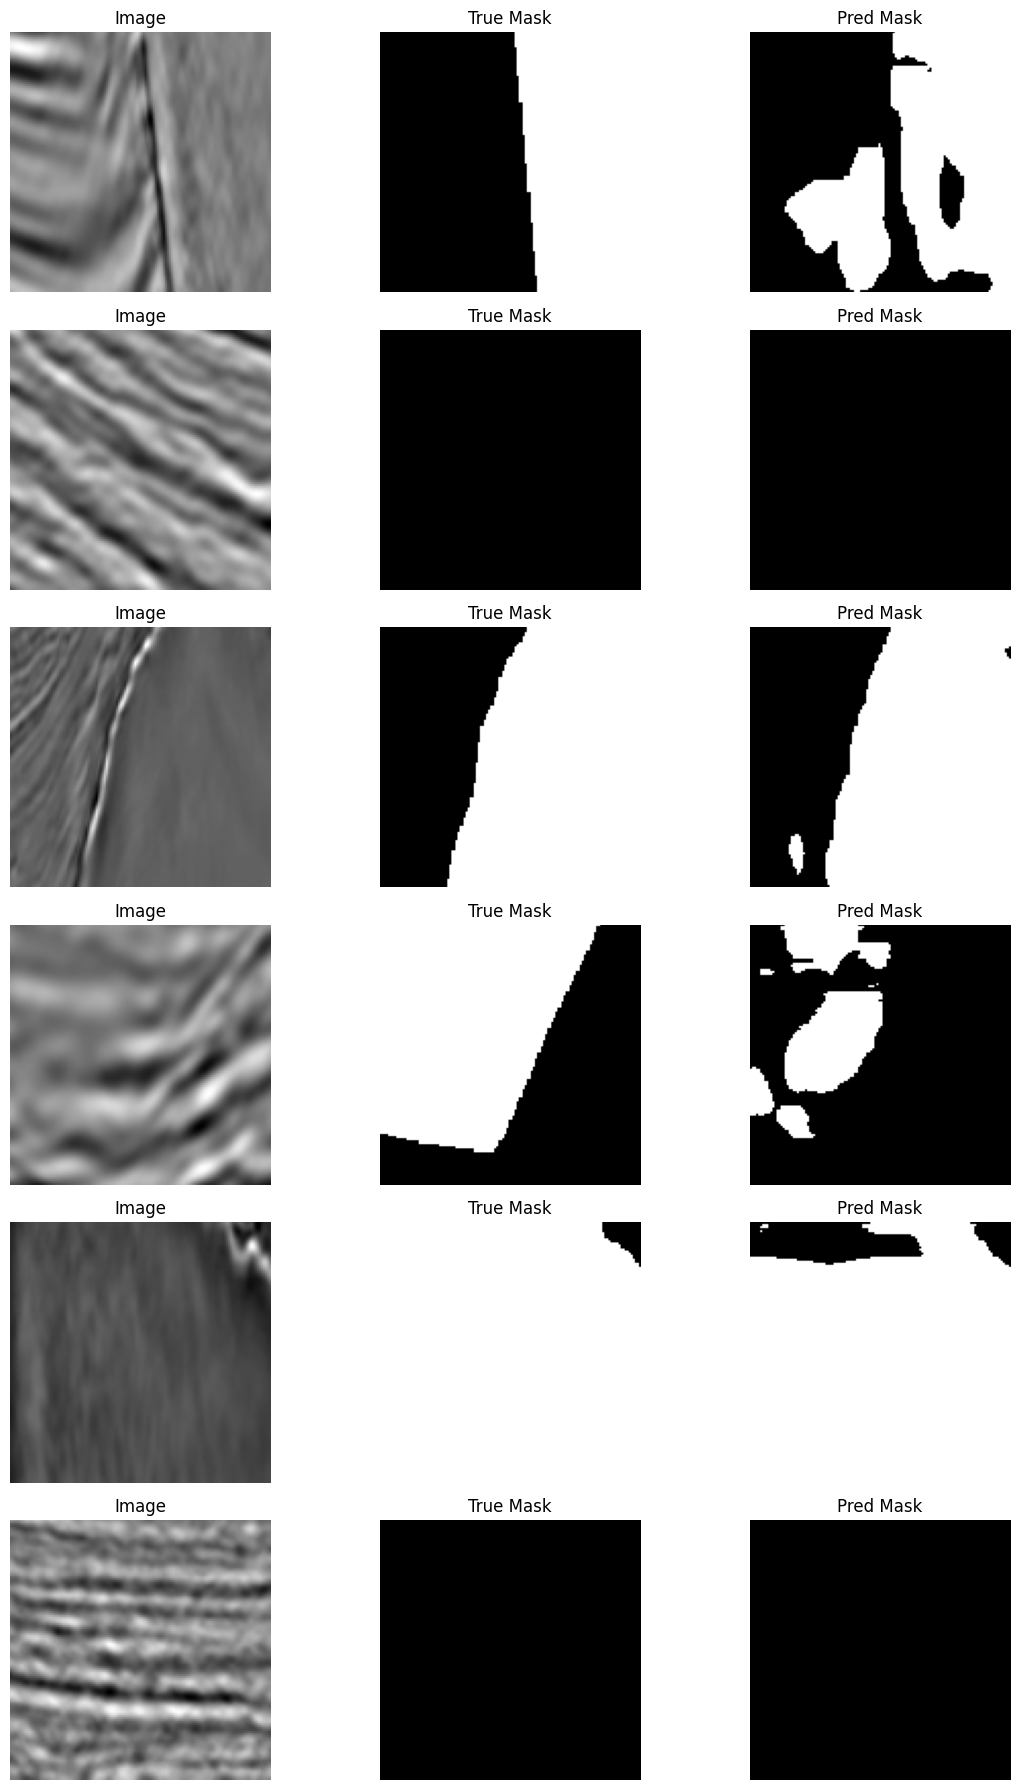

In [31]:
def show_predictions(model, ds, n=6, threshold=0.5):
    imgs, msks = next(iter(ds))
    preds = model.predict(imgs, verbose=0)
    preds_bin = (preds > threshold).astype(np.uint8)

    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        plt.subplot(n, 3, 3*i+1)
        plt.imshow(tf.squeeze(imgs[i]), cmap="gray")
        plt.title("Image")
        plt.axis("off")

        plt.subplot(n, 3, 3*i+2)
        plt.imshow(tf.squeeze(msks[i]), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(n, 3, 3*i+3)
        plt.imshow(np.squeeze(preds_bin[i]), cmap="gray")
        plt.title("Pred Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, val_ds, n=6, threshold=0.5)


Pored numeričkih metrika, vizuelno upoređivanje predikovanih maski sa ground-truth maskama pomaže da se uoči da li model prepoznaje relevantne obrasce, kao i gde greši (npr. greške na granicama, propuštanje malih solnih struktura, fragmentacija predikcije). Ovaj korak je posebno koristan u segmentaciji, jer mali pomaci granica mogu imati veliki uticaj na praktičnu interpretaciju.

### Kratka diskusija na osnovu baseline modela

Rezultati dobijeni treniranjem jednostavnog baseline CNN modela pokazuju da model uspešno uči relevantne obrasce prisutne u seizmičkim slikama. Pixel-wise evaluacija na validacionom skupu daje Accuracy ≈ 0.90, što ukazuje na visok procenat tačno klasifikovanih piksela. Međutim, s obzirom na izraženu neuravnoteženost klasa, accuracy sama po sebi nije dovoljna za potpunu procenu kvaliteta modela.

Detaljnija analiza pokazuje Precision ≈ 0.84 i Recall ≈ 0.71, što znači da model relativno precizno detektuje piksele koji pripadaju klasi salt, ali i dalje propušta deo stvarnih solnih struktura. Ovo je dodatno potvrđeno F1-score vrednošću ≈ 0.77, koja predstavlja uravnoteženu meru između preciznosti i odziva i ukazuje na solidne performanse baseline modela, ali i značajan prostor za unapređenje.

Vizuelna analiza predikcija potvrđuje numeričke rezultate: model uspešno prepoznaje veće i jasnije solne strukture, dok se greške najčešće javljaju na granicama između soli i sedimenata, kao i kod veoma malih ili fragmentisanih solnih regiona. Ovakvo ponašanje je očekivano za jednostavnu encoder–decoder arhitekturu bez skip konekcija, posebno u uslovima šuma i slabog kontrasta.

Dobijeni rezultati potvrđuju da su podaci adekvatno pripremljeni i da pretprocesiranje nije uvelo značajne artefakte. Istovremeno, analiza jasno ukazuje na glavne pravce za unapređenje u narednim fazama projekta, uključujući korišćenje naprednijih arhitektura (npr. U-Net sa skip konekcijama), primenu loss funkcija prilagođenih neuravnoteženim klasama (Dice ili kombinovani loss), kao i bogatiju augmentaciju podataka. Ovaj baseline model tako predstavlja stabilnu i opravdanu polaznu tačku za dalju optimizaciju u okviru Kontrolnih tačaka 3.